# Conformado campo cercano

**@Author**: Luis Miguel Sánchez Brea

**@Date**:   15/10/2020

**Information**: R. W. Gerchberg and W. O. Saxton, “A Practical Algorithm for the Determination of Phase from Image and Diffraction Plane Pictures,” Optik (Stuttg)., vol. 35, no. 2, pp. 237–246, 1972. 

## Introduction
Vamos a realizar un sistema multilente pero con multiplexación de fase. Lo hacemos con el algorithm de Gerchberg-Saxton a una distancia finita (focal) y con el objetivo de puntos. 

He comprobado que si ponemos un único punto la máscara es una lente de fresnel
* Para distancias cortas, las multilentes se multiplexan en el espacio.
* Para distanas medias, quedan multiplexadas en la fase, es decir, se combinan en todos.
* Para distancias largas, quedan una serie de cuadraditos, como si fueran redes de Dammann, pero no es periódico ya que a los bordes quedan distintas.

In [1]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

from py_aocg.ifta.algorithms import GS_scalar_Fresnel
from py_aocg.ifta.parameters import RMSE,  verify_mask,  make_binary

number of processors: 8
total memory        : 15.5 Gb
available memory    : 57 %
max frequency       : 3100 GHz
py_aocg
number of processors: 8
total memory        : 15.5 Gb
available memory    : 57 %
max frequency       : 3100 GHz


In [2]:
def GS_scalar_Fresnel2( z, source, target, kind, is_binary, num_steps, phase=np.pi, has_draw=False):
    """
    # kin(str): 'amplitude' or 'phase'
    is_binary (bool): 
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    wavelength = target.wavelength
    num_x = len(x)
    num_y = len(y)

    

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    field_z = Scalar_mask_XY(x, y, wavelength)

    u_target = np.abs(target.u)
    I_result = np.abs(target.u)**2
    I_result_mean = I_result.mean()

    field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))

    for i in range(num_steps):
        DOE = field_z.RS(z=-z, new_field=True)
        quality = DOE.quality
            
        if kind == 'amplitude':
            mask = np.abs(DOE.u)
            if is_binary:
                mask=make_binary(mask, 0, 1, 0.5)
            DOE.u=mask
            

        elif kind=='phase':
            mask = np.angle(DOE.u)
            if is_binary:
                mask=make_binary(mask, -np.pi/2, np.pi/2, 0)
                
            DOE.u = np.exp(1j * mask)       
        
        field_z = (source * DOE).RS(z=z, new_field=True)
        I_z = np.abs(field_z.u)**2
        I_z = I_z * I_result_mean / I_z.mean()

        field_z.u = u_target * np.exp(1j * np.angle(field_z.u))

        # if has_mask:
        #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

        error = RMSE(I_result, I_z)
        print("{}/{} - q: {:2.2f} error {:2.6f}".format(
            i, num_steps, quality, error),
              end='\r')
        errors[i] = error

    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)
        mask = mask * target.u
        

    if has_draw:
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return DOE, mask_final, errors

## Mask

In [33]:
num_x=256
num_y=256
DOE_size=20*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [34]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()

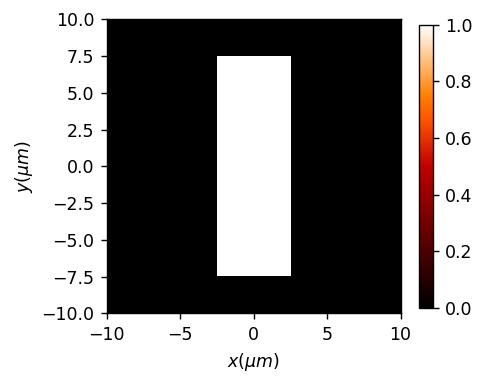

In [35]:
target=Scalar_mask_XY(x,y,wavelength)
target1=Scalar_mask_XY(x,y,wavelength)
target2=Scalar_mask_XY(x,y,wavelength)


target1.ring(r0=(0,0), radius1=2*um, radius2=4*um)
target2.ring(r0=(0,0), radius1=5*um, radius2=6*um)
target = target1 + target2

target=Scalar_mask_XY(x,y,wavelength)

target.image('mascara1024.png')

target.square(r0=(0,0), size=(5,15), angle=0)


target.draw(has_colorbar='vertical');

## Direct propagation

In [36]:
z_distance=5*um


Good result: factor 6.04


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f3d924bf910>)

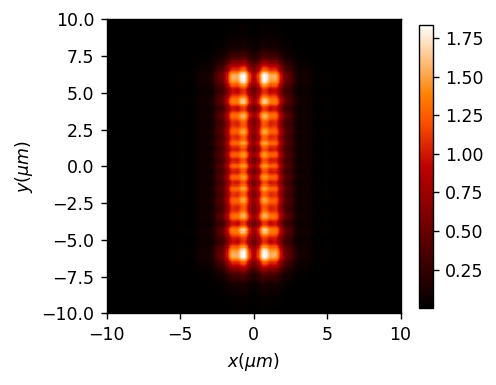

In [37]:
u_direct = target.RS(z=z_distance, verbose=True)
u_direct.draw(has_colorbar='vertical')

## Computation - continuous

In [38]:
num_steps=60

In [45]:
DOE, mask_final, errors = GS_scalar_Fresnel(z_distance, None,target, kind='phase', is_binary=True,  num_steps=num_steps)

(0.0, 0.007061966243115421)

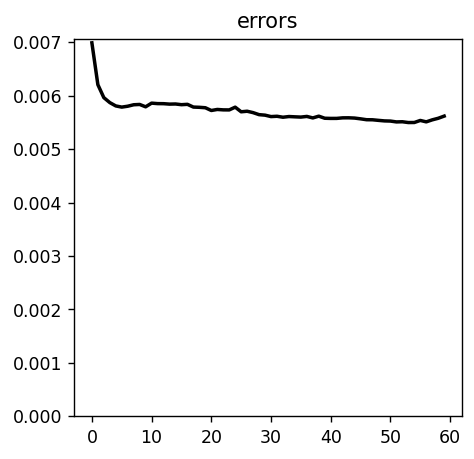

In [46]:
plt.plot(errors,'k', lw=2)
plt.title('errors'); plt.ylim(ymin=0)

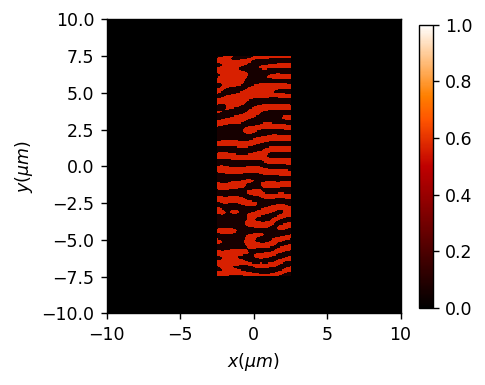

In [47]:
mask_final.draw('intensity', has_colorbar='vertical');

Good result: factor 6.04


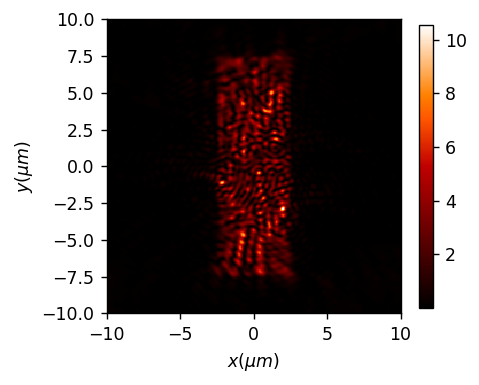

In [48]:
u_final = DOE.RS(z=z_distance, verbose=True)
u_final.draw(has_colorbar='vertical');

In [49]:
RMSE(u_final.intensity(),target.intensity()), RMSE(u_direct.intensity(),target.intensity())    

(0.005616754921169795, 0.003870869086931601)

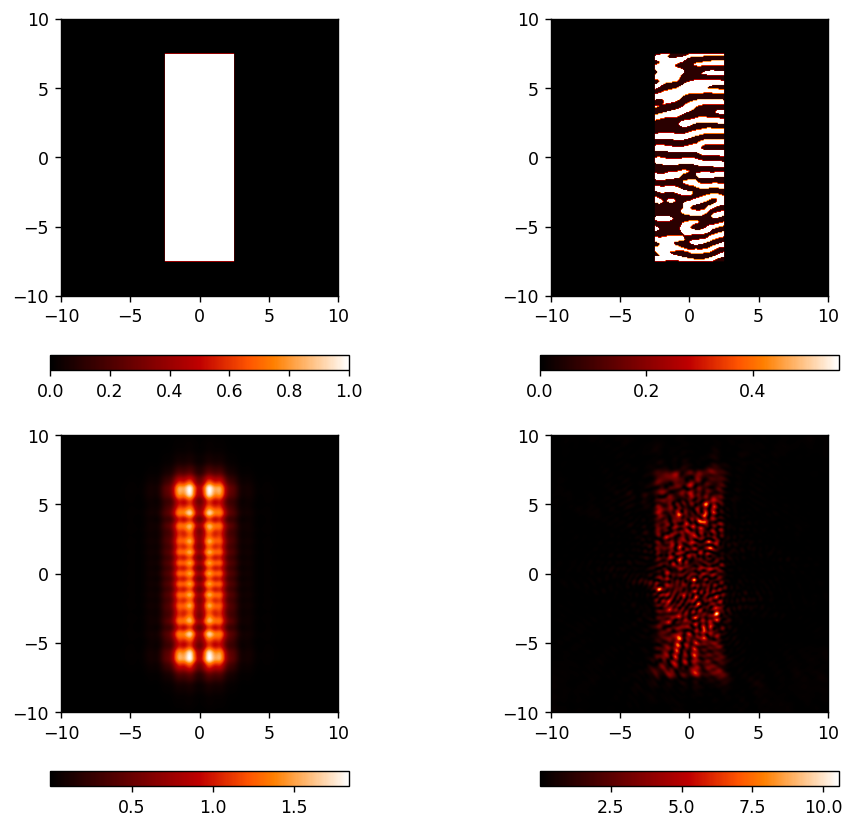

In [50]:
draw_several_fields((target, mask_final, u_direct,  u_final))
plt.tight_layout()